In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from scipy.special import softmax

In [5]:
from gradient_growing_trees.tree import GradientGrowingTreeRegressor

In [3]:
from sklearn.datasets import load_breast_cancer

In [4]:
bc_X, bc_y = load_breast_cancer(return_X_y=True)

Classification labels for `GradientGrowingTreeRegressor` should be one-hot encoded,
so the basic classifier can be trained with:
```
model = GradientGrowingTreeRegressor(lam_2=0.1, criterion='batch_gce', splitter='best')
model.fit(
    X,
    OneHotEncoder(sparse_output=False).fit_transform(y[:, np.newaxis])  # one-hot encoded targets
)
```

Comparison for different tree max depths:

In [33]:
def make_comparison(X, y, models, depth_range=(1, 9), n_repeats=20, n_splits=5):
    all_results = dict()

    for depth in range(*depth_range):
        rand_results = dict()
        for name, model_factory in models.items():
            cur_res = []
            for s in range(n_repeats):
                kfold = KFold(n_splits=n_splits, shuffle=True, random_state=s)
                for i, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
                    m = model_factory(depth)
                    cur_y = y[train_idx]
                    if isinstance(m, GradientGrowingTreeRegressor):
                        cur_y = OneHotEncoder(sparse_output=False).fit_transform(y[train_idx][:, np.newaxis])

                    m.fit(X[train_idx], cur_y)

                    if not isinstance(m, GradientGrowingTreeRegressor):
                        preds = m.predict_proba(X[test_idx])[:, 1]
                    else:
                        preds = softmax(m.predict(X[test_idx]), axis=1)[:, 1]

                    score = roc_auc_score(y[test_idx], preds)
                    cur_res.append(score)
            rand_results[name] = np.array(cur_res)
        all_results[depth] = rand_results

    df_data = defaultdict(list)

    for d, res in all_results.items():
        for name, values in res.items():
            for v in values:
                df_data['name'].append(name)
                df_data['depth'].append(d)
                df_data['ROC-AUC'].append(v)

    df = pd.DataFrame(df_data)
    return df


In [34]:
models = {
    'CART': lambda d: DecisionTreeClassifier(max_depth=d),
    'Extra': lambda d: DecisionTreeClassifier(max_depth=d, splitter='random'),
    'GGT (l2=0.1)': lambda d: GradientGrowingTreeRegressor(lam_2=0.1, lr=1.0, criterion='batch_gce', splitter='best', max_depth=d, random_state=1),
    'GGT (l2=0.5)': lambda d: GradientGrowingTreeRegressor(lam_2=0.5, lr=1.0, criterion='batch_gce', splitter='best', max_depth=d, random_state=1),
}

In [35]:
df = make_comparison(bc_X, bc_y, models, depth_range=(1, 31))

In [36]:
t = pd.pivot_table(df, values='ROC-AUC', index='depth', columns='name').style.highlight_max(
    axis=1,
    props="font-weight: bold",
).format("{:0.3f}")
t

name,CART,Extra,GGT (l2=0.1),GGT (l2=0.5)
depth,,,,
1,0.879,0.855,0.890,0.890
2,0.937,0.934,0.959,0.946
3,0.935,0.952,0.971,0.964
4,0.927,0.954,0.973,0.970
5,0.920,0.949,0.973,0.971
6,0.924,0.936,0.974,0.973
7,0.924,0.932,0.974,0.973
8,0.925,0.928,0.975,0.973
9,0.921,0.929,0.975,0.973


<Axes: xlabel='depth', ylabel='ROC-AUC'>

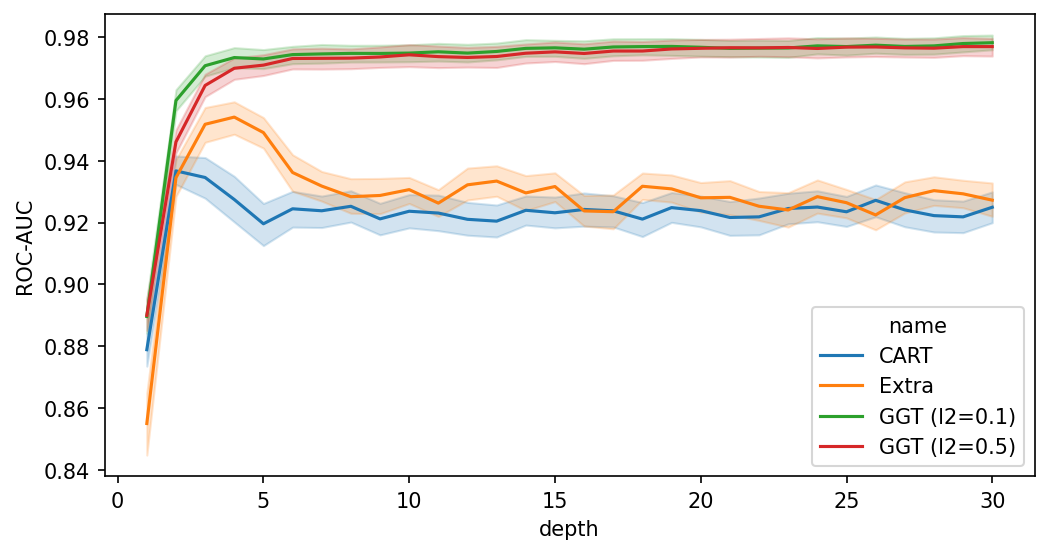

In [37]:
plt.figure(figsize=(8, 4), dpi=150)
sns.lineplot(df, x='depth', y='ROC-AUC', hue='name')

It can be seen that the Gradient Growing Trees are not subject to overfitting when the depth is large,
which is not the case for the classical trees (CART, Extra).